<a href="https://colab.research.google.com/github/pranay8297/fastaip2/blob/main/Diffusion_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ipdb
!pip install torcheval
!pip install -Uqq git+https://github.com/fastai/course22p2
!pip install tqdm
!pip install accelerate

In [ ]:
import torch
import math
import numpy as np
import fastcore.all as fc
import matplotlib as mpl, matplotlib.pyplot as plt
import time
import numpy
import pickle
import os
# import lpips

from pathlib import Path
from PIL import Image
from tqdm import tqdm
from scipy.linalg import sqrtm
from functools import partial
from ipdb import set_trace as st
from accelerate import Accelerator
from datasets import load_dataset

from torch import nn
from torch import optim
from torch import autocast
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler
from torch.optim import lr_scheduler
from torchvision.transforms.functional import to_tensor, resize
from torchvision import transforms
from torchvision.transforms import v2, InterpolationMode
# from torcheval.metrics import MulticlassAccuracy
import torchvision.transforms.functional as TF

from miniai.datasets import *
from miniai.learner import *
from miniai.augment import *
from miniai.activations import *
from miniai.init import *

from google.colab import drive
drive.mount('/content/drive')

mpl.rcParams['image.cmap'] = 'gray_r'

set_seed(42)
mdl_path = Path('drive/MyDrive/fastai_p2/models/')

IMAGENET_MEAN = torch.tensor([0.4810, 0.4482, 0.3968])
IMAGENET_STD = torch.tensor([0.2760, 0.2683, 0.2813])

IN_CHANNELS_RGB = 3
IN_CHANNELS_GRAY_SCALE = 1

In [4]:
IMAGENET_IN_CHANNELS, IMAGENET_OUT_CHANNELS = 3, 3
FMNIST_IN_CHANNELS, FMNIST_OUT_CHANNELS = 1, 1

In [5]:
dname, xn, yn = 'fashion_mnist', 'image', 'label'
dsd = load_dataset(dname)

@inplace
def transformi(b): b['image'] = [(resize(to_tensor(o), (32, 32), antialias = True))*2. - 1. for o in b['image']]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, batch_size = 256, num_workers=2)

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [6]:
def flatten_mse(yhat, targ): return F.mse_loss(yhat.flatten(), targ.flatten())

class BaseSchedulerCB(Callback):
  def __init__(self, sched_class): self.sched_class = sched_class
  def before_fit(self, learn): self.sched = self.sched_class(learn.opt)
  def step(self, learn):
    if not learn.training: return
    self.sched.step()

class BatchSchedulerCB(BaseSchedulerCB):
  def __init__(self, sched_class):super().__init__(sched_class)
  def after_batch(self, learn): self.step(learn)

def noisify_img(cb_obj, x_0):
  n = x_0.shape[0]
  device = x_0.device
  noise = torch.randn(x_0.shape, device = device)
  ts = torch.randint(0, cb_obj.n_steps, size = (n,), device = device, dtype = torch.long)

  if cb_obj.alpha_bar.device != device: cb_obj.alpha_bar = cb_obj.alpha_bar.to(device)

  c1 = cb_obj.alpha_bar[ts].sqrt()[:, None, None, None].to(device)
  c2 = (1 - cb_obj.alpha_bar[ts]).sqrt()[:, None, None, None].to(device)
  x_t = c1*x_0 + c2*noise

  return (x_t, ts), noise

class DDPMPrep(Callback):
  def __init__(self, n_steps = 1000, beta_min = 0.0001, beta_max = 0.02):
    fc.store_attr()
    self.beta = torch.linspace(beta_min, beta_max, n_steps)
    self.alpha = 1. - self.beta
    self.alpha_bar = self.alpha.cumprod(0)
    self.sigma = self.beta.sqrt()

  def before_batch(self, learn): learn.batch = noisify_img(self, learn.batch[0])

class AccLearner(TrainLearner):

  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.aclr = Accelerator()
    self.opt = self.opt_func(self.model.parameters(), self.lr)
    self.model, self.opt, self.dls.train, self.dls.valid = self.aclr.prepare(self.model, self.opt, self.dls.train, self.dls.valid)

  def backward(self): self.aclr.backward(self.loss)

# Jermeys Code

In [7]:
def get_layer():
  return nn.Sequential(
      nn.Linear(10, 10),
      nn.Linear(10, 10),nn.Linear(10, 10)
  )

In [8]:
layers = nn.Sequential(*[get_layer() for i in range(4)])

In [9]:
len(layers)

4

In [4]:
def unet_conv(ni, nf, ks=3, stride=1, act=nn.SiLU, norm=None, bias=True):
    layers = nn.Sequential()
    if norm: layers.append(norm(ni))
    if act : layers.append(act())
    layers.append(nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias))
    return layers

In [6]:
class UnetResBlock(nn.Module):
    def __init__(self, ni, nf=None, ks=3, act=nn.SiLU, norm=nn.BatchNorm2d):
        super().__init__()
        if nf is None: nf = ni
        self.convs = nn.Sequential(unet_conv(ni, nf, ks, act=act, norm=norm),
                                   unet_conv(nf, nf, ks, act=act, norm=norm))
        self.idconv = fc.noop if ni==nf else nn.Conv2d(ni, nf, 1)

    def forward(self, x): return self.convs(x) + self.idconv(x)

In [7]:
class SaveModule:
    def forward(self, x, *args, **kwargs):
        self.saved = super().forward(x, *args, **kwargs)
        return self.saved

class SavedResBlock(SaveModule, UnetResBlock): pass
class SavedConv(SaveModule, nn.Conv2d): pass

In [8]:
def down_block(ni, nf, add_down=True, num_layers=1):
    res = nn.Sequential(*[SavedResBlock(ni=ni if i==0 else nf, nf=nf)
                         for i in range(num_layers)])
    if add_down: res.append(SavedConv(nf, nf, 3, stride=2, padding=1))
    return res


In [9]:
def upsample(nf): return nn.Sequential(nn.Upsample(scale_factor=2.), nn.Conv2d(nf, nf, 3, padding=1))


In [10]:
class UpBlock(nn.Module):
    def __init__(self, ni, prev_nf, nf, add_up=True, num_layers=2):
        super().__init__()
        self.resnets = nn.ModuleList(
            [UnetResBlock((prev_nf if i==0 else nf)+(ni if (i==num_layers-1) else nf), nf)
            for i in range(num_layers)])
        self.up = upsample(nf) if add_up else nn.Identity()

    def forward(self, x, ups):
        for resnet in self.resnets: x = resnet(torch.cat([x, ups.pop()], dim=1))
        return self.up(x)

In [23]:
class UNet2DModel(nn.Module):
    def __init__( self, in_channels=3, out_channels=3, nfs=(224,448,672,896), num_layers=1):
        super().__init__()
        self.conv_in = nn.Conv2d(in_channels, nfs[0], kernel_size=3, padding=1)
        nf = nfs[0]
        self.downs = nn.Sequential()
        for i in range(len(nfs)):
            ni = nf
            nf = nfs[i]
            self.downs.append(down_block(ni, nf, add_down=i!=len(nfs)-1, num_layers=num_layers))
        self.mid_block = UnetResBlock(nfs[-1])

        rev_nfs = list(reversed(nfs))
        nf = rev_nfs[0]
        self.ups = nn.ModuleList()
        for i in range(len(nfs)):
            prev_nf = nf
            nf = rev_nfs[i]
            ni = rev_nfs[min(i+1, len(nfs)-1)]
            self.ups.append(UpBlock(ni, prev_nf, nf, add_up=i!=len(nfs)-1, num_layers=num_layers+1))
        self.conv_out = unet_conv(nfs[0], out_channels, act=nn.SiLU, norm=nn.BatchNorm2d)

    def forward(self, inp):
        st()
        x = self.conv_in(inp[0])
        saved = [x]
        x = self.downs(x)
        saved += [p.saved for o in self.downs for p in o]
        x = self.mid_block(x)
        for block in self.ups: x = block(x, saved)
        return self.conv_out(x)

In [24]:
model = UNet2DModel(in_channels=1, out_channels=1, nfs=(32,64,128,256), num_layers=2)

In [25]:
x = torch.randn(64, 1, 32, 32)
out = model([x])


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.10/bdb.py", line 336, in set_trace
    sys.settrace(self.trace_dispatch)



> <ipython-input-23-734baf59ad32>(25)forward()
     24         st()
---> 25         x = self.conv_in(inp[0])
     26         saved = [x]

ipdb> n
> <ipython-input-23-734baf59ad32>(26)forward()
     25         x = self.conv_in(inp[0])
---> 26         saved = [x]
     27         x = self.downs(x)

ipdb> x.shape
torch.Size([64, 32, 32, 32])
ipdb> n
> <ipython-input-23-734baf59ad32>(27)forward()
     26         saved = [x]
---> 27         x = self.downs(x)
     28         saved += [p.saved for o in self.downs for p in o]

ipdb> n
> <ipython-input-23-734baf59ad32>(28)forward()
     27         x = self.downs(x)
---> 28         saved += [p.saved for o in self.downs for p in o]
     29         x = self.mid_block(x)

ipdb> x.shape
torch.Size([64, 256, 4, 4])
ipdb> self.down
*** AttributeError: 'UNet2DModel' object has no attribute 'down'
ipdb> self.downs
Sequential(
  (0): Sequential(
    (0): SavedResBlock(
      (convs): Sequential(
        (0): Sequential(
          (0): BatchNorm2d(32, eps=


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.10/bdb.py", line 361, in set_quit
    sys.settrace(None)



# Test Exps and Viz

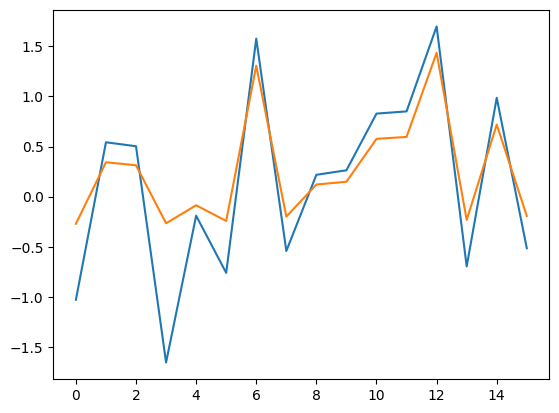

In [39]:
x = torch.randn(16)
plt.plot(x)
plt.plot(nn.SiLU()(x))

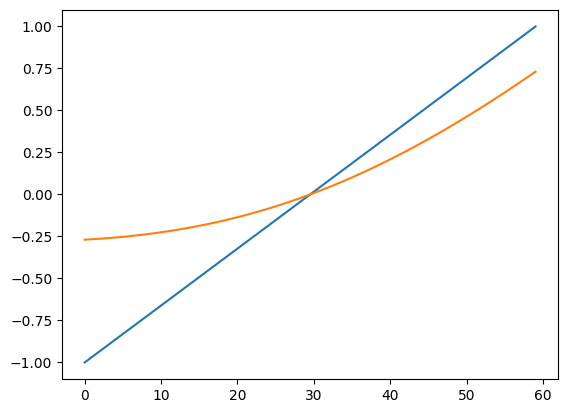

In [40]:
x = torch.linspace(-1, 1, 60)
plt.plot(x)
plt.plot(nn.SiLU()(x))

# Without Timestep Implementation

**Plan**

3 versions of diffusion unet should be implemented.
1. What ever is implemented in diffusers
2. Replace Unet Conv with my implementation of pre act conv
3. Tweak the arch in a way that instead of adding skip connections everywhere, just limit it to the starting block.

In [ ]:
# Basic Pre Act Conv -
# Saved Conv
# Down Block
# Up Block

In [8]:
def _pre_conv(ni, nf, kernel_size = 3, stride = 1, act = nn.SiLU, norm = nn.BatchNorm2d):
  layers = []
  if act: layers.append(act())
  if norm: layers.append(norm(ni))
  layers.append(nn.Conv2d(ni, nf, kernel_size, stride = stride, padding = kernel_size//2, bias = True))
  return nn.Sequential(*layers)

class ResBlock(nn.Module):
  def __init__(self, ni, nf, kernel_size = 3, stride = 1, act = nn.SiLU, norm = nn.BatchNorm2d):
    super().__init__()
    self.id_conv = nn.Conv2d(ni, nf, kernel_size = 1, stride = stride) if ni != nf else fc.noop
    self.convs = nn.Sequential(
        _pre_conv(ni, nf, kernel_size, 1, act, norm),
        _pre_conv(nf, nf, kernel_size, stride, act, norm)
    )

  def forward(self, x): return self.id_conv(x) + self.convs(x)

class SM:
  def forward(self, *args, **kwargs):
    self.saved = super().forward(*args, **kwargs)
    return self.saved

class SConv(SM, nn.Conv2d): pass
class SResBlock(SM, ResBlock): pass

def down_block(ni, nf, n_layers = 1, add_down = True, act = nn.SiLU, norm = nn.BatchNorm2d):
  layers = [SResBlock(ni if i == 0 else nf, nf, act = act, norm = norm) for i in range(n_layers)]
  if add_down == True: layers.append(SConv(nf, nf, kernel_size = 3, stride = 2, padding = 1))
  return nn.Sequential(*layers)

def up_conv(ni, nf, kernel_size = 3):
  return nn.Sequential(nn.Upsample(scale_factor = 2), nn.Conv2d(ni, nf, stride = 1, kernel_size = kernel_size, padding = kernel_size//2))

class UpBlock(nn.Module):
  def __init__(self, ni, nf, prev_nf, add_up = True, n_layers = 2, act = nn.SiLU, norm = nn.BatchNorm2d):
    super().__init__()
    self.blocks = nn.ModuleList([])
    for i in range(n_layers):
      if i == 0: inc = ni + nf
      elif i == n_layers - 1: inc = prev_nf + nf
      else: inc = 2*nf
      self.blocks.append(ResBlock(inc, nf, act = act, norm = norm))

    self.up = up_conv(nf, nf) if add_up else nn.Identity()

  def forward(self, x, ups):
    for block in self.blocks: x = block(torch.cat([ups.pop(), x], dim = 1))
    return self.up(x)

class DiffusionUNET(nn.Module):
  def __init__(self, in_channels = FMNIST_IN_CHANNELS, out_channels = FMNIST_OUT_CHANNELS,
                                                    nfs = [64, 128, 256, 512], n_layers = 2):
    super().__init__()
    self.first_c = nn.Conv2d(in_channels, nfs[0], kernel_size = 3, padding = 1, bias = True)
    downs, ni = [], nfs[0]
    for i, nf in enumerate(nfs):
      downs.append(down_block(ni, nf, n_layers = n_layers, add_down = False if i == (len(nfs)-1) else True))
      ni = nf
    self.downs = nn.Sequential(*downs)
    self.mid_c = ResBlock(nf, nf)
    ups, ni, nfs  = [], nfs[-1], list(reversed(nfs))
    for i, nf in enumerate(nfs):
      prev_nf = nfs[i + 1] if i < len(nfs) - 1 else nfs[i]
      ups.append(UpBlock(ni, nf, prev_nf, add_up = True if i < len(nfs) - 1 else False, n_layers = n_layers + 1))
      ni = nf
    self.ups = nn.ModuleList(ups)
    self.final_c = _pre_conv(nfs[-1], out_channels)

  def forward(self, inp):
    x, t = inp
    x = self.first_c(x)
    acts = [x]
    x = self.downs(x)
    x = self.mid_c(x)
    acts += [i.saved for j in self.downs for i in j]
    for up in self.ups: x = up(x, acts)
    return self.final_c(x)

tensor(-0.0005) tensor(1.0009)


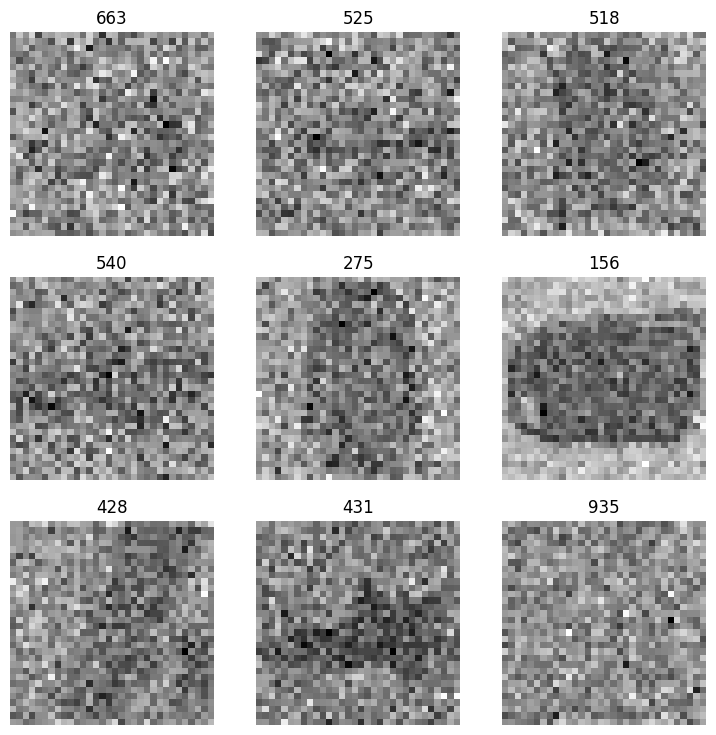

In [9]:
x, y = next(iter(dls.train))
(xout, t), y = noisify_img(DDPMPrep(beta_max=0.01), x)
print(y.mean(), y.std())
show_images(xout[:9], titles= [str(i.item()) for i in t[:9]])

loss,epoch,train
0.167,0,train
0.087,0,eval
0.064,1,train
0.068,1,eval
0.052,2,train
0.048,2,eval
0.046,3,train
0.045,3,eval


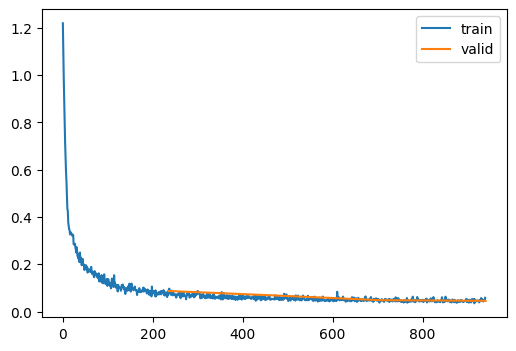

In [23]:
lr_max, epochs = 5e-04, 4
cbs = [
          DeviceCB(torch.device('cuda' if torch.cuda.is_available() else 'cpu')),
          MetricsCB(),
          ProgressCB(plot = True),
          DDPMPrep(beta_max=0.01),
          BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = lr_max, epochs = epochs, steps_per_epoch = len(dls.train))),
      ]
model =  DiffusionUNET(nfs = [64, 128, 256, 512])
learner = AccLearner(model, dls, loss_func = flatten_mse, lr = lr_max, cbs = cbs, opt_func = partial(torch.optim.AdamW, eps = 1e-05))
learner.fit(epochs)

In [21]:
del model
del learner
clean_mem()

# With Timestep Implentation

1. timestep logic
2. New Implementation of All the blocks with timestep inclusion logic

In [50]:
tsteps = torch.linspace(-10, 10, 100)
max_t = 100
nemb = 16
points = -1*math.log(max_t) * torch.linspace(0, 1, nemb//2)

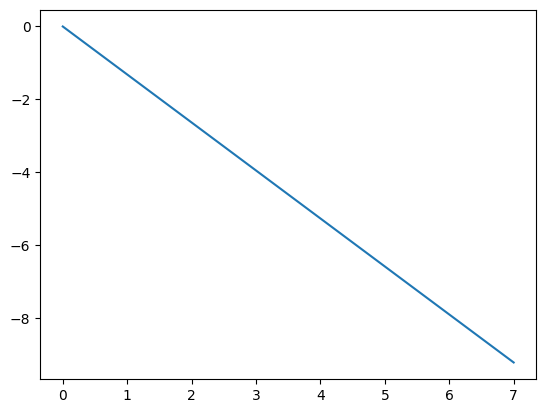

In [45]:
plt.plot(points)

In [51]:
points_dist = tsteps[:, None] * points[None, :].exp()
points_dist.shape

torch.Size([100, 8])

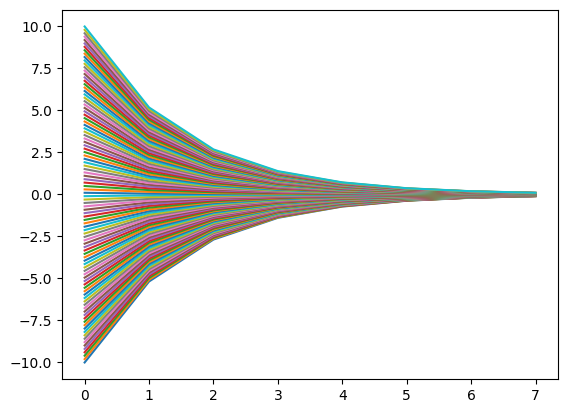

In [40]:
for i in points_dist: plt.plot(i)

<Axes: >

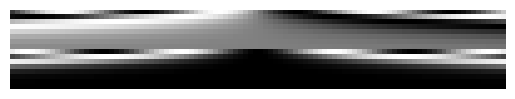

In [52]:
tembs = torch.cat((torch.sin(points_dist), torch.cos(points_dist)), dim = 1)
show_image(tembs.T)

In [53]:
def get_tembs(nsteps, nemb = 32, max_steps = 1000):
  tsteps = torch.linspace(-10, 10, nsteps)
  points = -1*math.log(max_steps) * torch.linspace(0, 1, nemb//2)
  points_dist = tsteps[:, None] * points[None, :].exp()
  return torch.cat((torch.sin(points_dist), torch.cos(points_dist)), dim = 1)

In [56]:
a = torch.randn(32, 64, 4, 4)
x, y = a.chunk(2, dim = 1)
x.shape, y.shape

(torch.Size([32, 32, 4, 4]), torch.Size([32, 32, 4, 4]))

In [57]:
class EmbResBlock(nn.Module):
  def __init__(self, ni, nf, n_emb, kernel_size = 3, stride = 1, act = nn.SiLU, norm = nn.BatchNorm2d):
    super().__init__()
    self.emb_proj = nn.Linear(n_emb, 2*nf)
    self.id_conv = nn.Conv2d(ni, nf, kernel_size = 1, stride = stride) if ni != nf else fc.noop
    self.conv1 = _pre_conv(ni, nf, kernel_size, 1, act, norm)
    self.conv2 = _pre_conv(nf, nf, kernel_size, stride, act, norm)

  def forward(self, x, t_emb):
    res = self.conv1(x)
    t_emb = self.emb_proj(t_emb)[:, :, None, None]  # bs, 2*nf
    scale, shift = t_emb.chunk(2, dim = 1)
    res = res + res * scale + shift
    return self.id_conv(x) + self.conv2(res)

class SEResBlock(SM, ResBlock): pass

def down_block(ni, nf, n_emb, n_layers = 1, add_down = True, act = nn.SiLU, norm = nn.BatchNorm2d):
  layers = [SEResBlock(ni if i == 0 else nf, nf, n_emb = n_emb, act = act, norm = norm) for i in range(n_layers)]
  if add_down == True: layers.append(SConv(nf, nf, kernel_size = 3, stride = 2, padding = 1))
  return nn.Sequential(*layers)

def up_conv(ni, nf, kernel_size = 3):
  return nn.Sequential(nn.Upsample(scale_factor = 2), nn.Conv2d(ni, nf, stride = 1, kernel_size = kernel_size, padding = kernel_size//2))

class UpBlock(nn.Module):
  def __init__(self, ni, nf, prev_nf, n_emb, add_up = True, n_layers = 2, act = nn.SiLU, norm = nn.BatchNorm2d):
    super().__init__()
    self.blocks = nn.ModuleList([])
    for i in range(n_layers):
      if i == 0: inc = ni + nf
      elif i == n_layers - 1: inc = prev_nf + nf
      else: inc = 2*nf
      self.blocks.append(EmbResBlock(inc, nf, n_emb = n_emb, act = act, norm = norm))

    self.up = up_conv(nf, nf) if add_up else nn.Identity()

  def forward(self, x, ups, t_emb):
    for block in self.blocks: x = block(torch.cat([ups.pop(), x], dim = 1), t_emb)
    return self.up(x)

class DiffusionUNET(nn.Module):
  def __init__(self, in_channels = FMNIST_IN_CHANNELS, out_channels = FMNIST_OUT_CHANNELS,
                                                    nfs = [64, 128, 256, 512], n_layers = 2, emb_dim = 16):
    super().__init__()

    n_emb = nfs[0]*4
    self.emb_mlp = nn.Sequential(nn.Linear(emb_dim, n_emb, bias = True),
                                 nn.BatchNorm1d(n_emb),
                                 nn.Linear(n_emb, n_emb, bias = True))

    self.first_c = nn.Conv2d(in_channels, nfs[0], kernel_size = 3, padding = 1, bias = True)
    downs, ni = [], nfs[0]
    for i, nf in enumerate(nfs):
      downs.append(down_block(ni, nf, n_emb = n_emb, n_layers = n_layers, add_down = False if i == (len(nfs)-1) else True))
      ni = nf

    self.downs = nn.Sequential(*downs)
    self.mid_c = EmbResBlock(nf, nf, n_emb = n_emb)

    ups, ni, nfs  = [], nfs[-1], list(reversed(nfs))
    for i, nf in enumerate(nfs):
      prev_nf = nfs[i + 1] if i < len(nfs) - 1 else nfs[i]
      ups.append(UpBlock(ni, nf, prev_nf, n_emb = n_emb, add_up = True if i < len(nfs) - 1 else False, n_layers = n_layers + 1))
      ni = nf
    self.ups = nn.ModuleList(ups)
    self.final_c = _pre_conv(nfs[-1], out_channels) # EmbResBlock(nf, nf, n_emb = n_emb)

  def forward(self, inp):
    x, ts = inp
    t_emb = self.emb_mlp(ts) # bs, 4*nfs[0]
    x = self.first_c(x)
    acts = [x]
    for block in self.downs: x = block(x, t_emb)
    x = self.mid_c(x, t_emb)
    acts += [i.saved for j in self.downs for i in j]
    for up in self.ups: x = up(x, acts, t_emb)
    return self.final_c(x)